In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.5 MB 8.8 MB/s 
     |████████████████████████████████| 7.6 MB 60.8 MB/s 
     |████████████████████████████████| 163 kB 71.0 MB/s 


In [ ]:
import pandas as pd
import numpy as np
from transformers import BertModel, BertTokenizer
from transformers import get_scheduler

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from tqdm import tqdm, trange
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, accuracy_score, recall_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
torch.cuda.is_available()

True

In [ ]:
class simpleProcessor():
    
    def __init__(self, priceFile, newsFile, tickerName, priceType):
        self.tickerName = tickerName
        self.priceType = priceType
        self.crypto_news = pd.read_csv(newsFile, index_col = [0]).sort_index()
        self.price_vol = pd.read_csv(priceFile, index_col= [0]).sort_index()
        self.crypto_price = self.price_vol[[tickerName + '-' + priceType]].shift(1)
        self.crypto_price.index = pd.to_datetime(self.crypto_price.index).tz_convert(None)
        self.crypto_news.index = pd.to_datetime(self.crypto_news.index)
        self.data = None
        
    def getData(self):
        data = self.crypto_news.merge(self.crypto_price, how = 'inner', left_index = True, right_index = True)
        data['returns'] = data[self.tickerName + '-' + self.priceType].pct_change().shift(-1)
        data['class'] = data['returns'] > 0
        data = data.iloc[:-1, :]
        
        self.data = data[~data.isna().any(axis = 1)][['Tweet', 'class']]
        self.data.columns = ['text', 'class']
        self.data['class'] = self.data['class'].map({True : 1, False : 0})
        
        return self.data.copy(), data
        

In [ ]:
class newsDataset(Dataset): 
    
    def __init__(self, df, tokenizer):
        self.labels = [i for i in df['class']]
        self.texts = [tokenizer(str(text), 
                                padding='max_length',
                                truncation = True, 
                                return_tensors='pt')
                      for text in df['text']]
        
    def __len__(self):
        return len(self.labels)
    
    def get_batch_labels(self, idx):
        return np.array(self.labels[idx])
    
    def get_batch_text(self, idx):
        return self.texts[idx]
    
    def __getitem__(self, idx):
        batch_texts = self.get_batch_text(idx)
        batch_labels = self.get_batch_labels(idx)
        
        return batch_texts, batch_labels

In [ ]:
class SentenceEmbedding(nn.Module):
    
    def __init__(self, pre_trained = 'bert-base-uncased'):
        super().__init__()
        
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.bert = BertModel.from_pretrained(pre_trained)
        self.bert.requires_grad_(False) #frozen parameters
        
    def forward(self, input_id, mask):     
        encoded_layers = self.bert(input_ids=input_id, attention_mask=mask)[1]
        
        return encoded_layers

In [ ]:
def evaluate(model, testLoader):
    model = model.to(model.device)
    preds = []
    with torch.no_grad():
      for test_inputs, test_labels in testLoader:

        mask = test_inputs['attention_mask'].to(model.device)
        input_id = test_inputs['input_ids'].squeeze(1).to(model.device)

        output = model(input_id, mask)

        output = output.detach().cpu().numpy()

        preds += list(output)        
    
    return preds

In [ ]:
class backtestMetrics:
    
    def __init__(self, df):
        self.df = df
        self.df_dailyreturn = (df - df.shift(1))/df.shift(1)
        self.N = len(df) - 1
        
    def get_return(self):
        return (np.power(self.df.iloc[-1,:]/self.df.iloc[0,:],365*24/self.N) - 1)[0]
    
    def get_vol(self):
        return (np.std(self.df_dailyreturn)*np.sqrt(365*24))[0]
    
    def get_sharpe(self):
        return (self.get_return()/self.get_vol())
    
    def get_cumReturn(self):
        return (self.df.iloc[-1,:]/self.df.iloc[0,:] - 1)[0]
    
    def get_maxdd(self):
        return ((np.maximum.accumulate(self.df) - self.df)/np.maximum.accumulate(self.df)).max()[0]
    
    def strategy_map(self, ticker, strategy_type):
        map1 = {'ticker': ticker,
        'strategy': strategy_type, 
        'annual_return': self.get_return(),
        'annual_vol': self.get_vol(),
        'annual_sharpe': self.get_sharpe(),
        'cum_return': self.get_cumReturn(),
        'maxDD': self.get_maxdd()}
        
        return map1

In [ ]:
def simpleBacktest(backtest, y_pred_test, data):
    
    backtest['signal'] = y_pred_test
    backtest_start_date = backtest.index[0]
    
    allBacktest = data[data.index >= backtest_start_date][['returns']]
    backtestTable = allBacktest.merge(backtest[['signal']], how = 'left', left_index=True, right_index=True)
    backtestTable = backtestTable.fillna(method = 'ffill') # maintain viewpoints
    
    def simpleBacktest(df):
        if(df[1] == 1):
            return df[0]
        return 0.0
    
    backtestTable['realized_returns'] = backtestTable.apply(lambda x: simpleBacktest(x), axis = 1)
    backtestTable['strat_nav'] = (1 + backtestTable['realized_returns']).cumprod()
    backtestTable['nav'] = (1 + backtestTable['returns']).cumprod()
    
    return backtestTable

In [ ]:
ticker = 'ETH'
train_data1, data = simpleProcessor('/content/gdrive/MyDrive/Colab Notebooks/price_vol.csv', '/content/gdrive/MyDrive/Colab Notebooks/eth_all.csv', ticker, 'close').getData()

In [ ]:
BERT_NAME = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(BERT_NAME)
allDataLoader = DataLoader(newsDataset(train_data1, tokenizer), batch_size = 32)
model = SentenceEmbedding()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
embeddings = evaluate(model, allDataLoader)

In [ ]:
embeddings_df = pd.DataFrame(embeddings, index = train_data1.index)
embeddings_df['class'] = train_data1['class']

In [ ]:
embeddings_df.to_csv("/content/gdrive/MyDrive/Colab Notebooks/{}.csv".format(ticker + '_embeddings'))

In [ ]:
n = embeddings_df.shape[0]
X_train = embeddings_df.iloc[:int(0.64*n), :-1]
y_train = embeddings_df.iloc[:int(0.64*n), -1:]
X_valid = embeddings_df.iloc[int(0.64*n):int(0.8*n), :-1]
y_valid = embeddings_df.iloc[int(0.64*n):int(0.8*n), -1:]
X_test = embeddings_df.iloc[int(0.8*n):, :-1]
y_test = embeddings_df.iloc[int(0.8*n):, -1:]
backtest = embeddings_df.iloc[int(0.8*n):, :]

In [ ]:
model = RandomForestClassifier(max_depth=2)

In [ ]:
model.fit(X_train, y_train)

RandomForestClassifier(max_depth=2)

In [ ]:
y_test_pred = model.predict(X_test)
y_test = list(y_test.iloc[:,0])

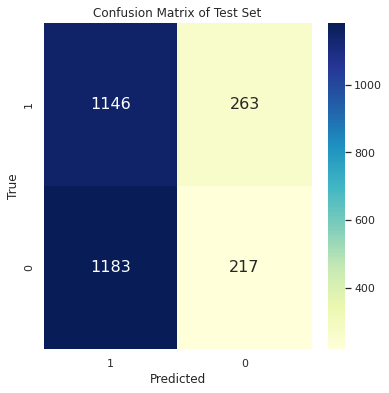

In [ ]:
cm_test = confusion_matrix(y_test, y_test_pred, labels = [1, 0])
plt.figure(figsize = (6,6))
s = sns.heatmap(cm_test, annot= True, fmt = 'd', annot_kws={'size': 16}, 
                cmap ='YlGnBu', xticklabels=[1, 0], yticklabels=[1, 0])
_ = s.set_xlabel('Predicted')
_ = s.set_ylabel('True')
_ = s.set_title('Confusion Matrix of Test Set')

In [ ]:
print(classification_report(y_test, y_test_pred, labels = [1, 0]))

              precision    recall  f1-score   support

           1       0.49      0.81      0.61      1409
           0       0.45      0.15      0.23      1400

    accuracy                           0.49      2809
   macro avg       0.47      0.48      0.42      2809
weighted avg       0.47      0.49      0.42      2809



In [ ]:
backtestTable = simpleBacktest(backtest, y_test_pred, data)

In [ ]:
backtestTable_name = 'rf_backtest_{}.csv'.format(ticker)
path = F"/content/gdrive/MyDrive/Colab Notebooks/{backtestTable_name}" 
backtestTable.to_csv(path)

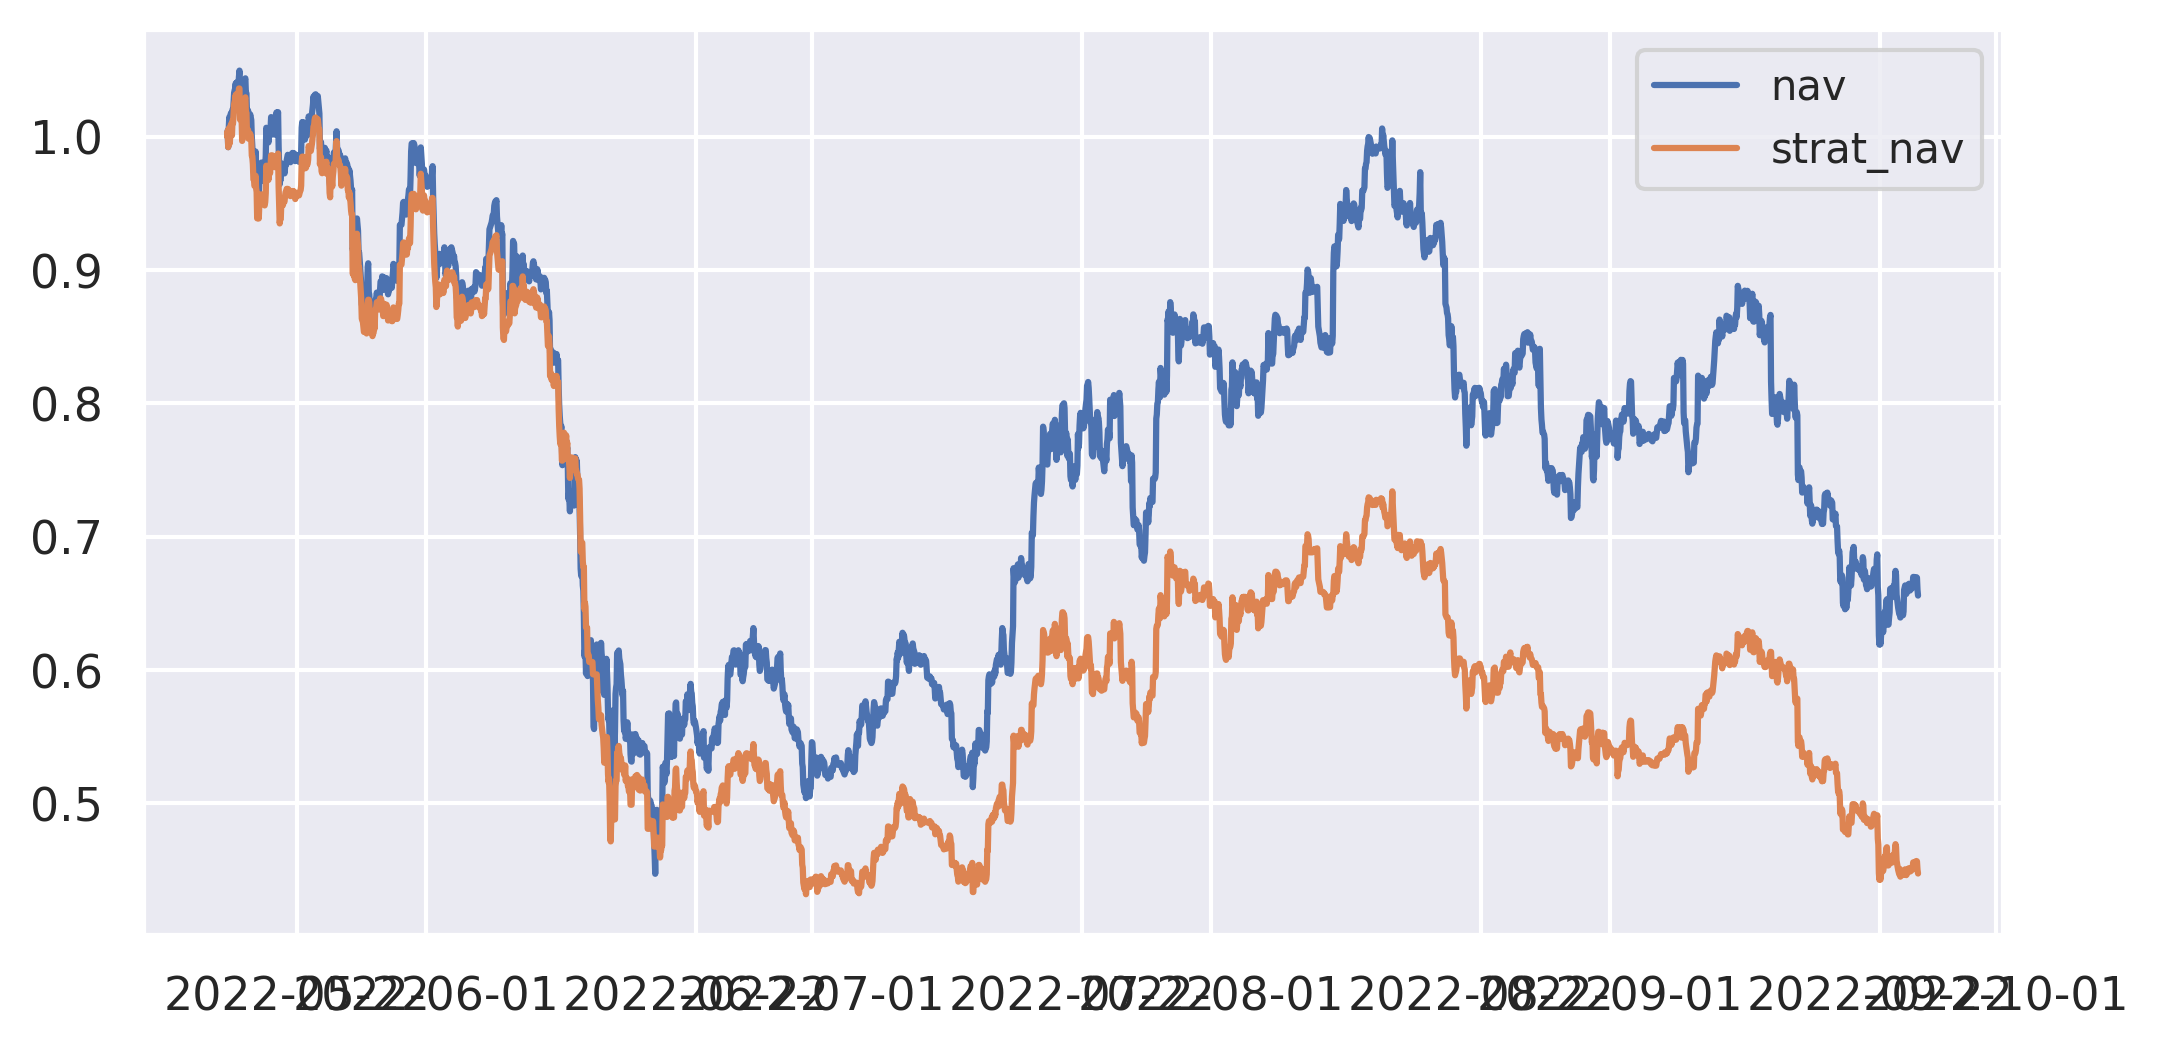

In [ ]:
plt.figure(figsize=(8, 4), dpi=300)
plt.plot(backtestTable['nav'], label='nav')
plt.plot(backtestTable['strat_nav'], label='strat_nav')
plt.legend(fontsize=10)